In [ ]:
from matplotlib import pyplot as plt
from tensorflow import keras
import cv2
from IPython.display import Image
import tensorflow as tf
from tensorflow.python.ops.gen_math_ops import imag
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import tensorflow.keras.backend as K
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import load_img
import os
import dlib
from tensorflow.keras import regularizers
from imutils import face_utils




from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
from random import randint
import numpy 
from PIL import Image
import theano

import matplotlib.image as mpimg
import dlib


In [ ]:
model = tf.keras.models.load_model("/home/data/data/kodeiri/ML_project/saved_model/my_model4")

In [ ]:
detector = dlib.cnn_face_detection_model_v1('/home/data/data/kodeiri/ML_project/dogHeadDetector.dat')
predictor = dlib.shape_predictor('/home/data/data/kodeiri/ML_project/landmarkDetector.dat')

In [ ]:
CATEGORIES = ["Adult", "Senior", "Young"]

In [ ]:
# wyszukiwanie zdjęcia na białym tle
def photo_detector(src_image):

    img_in = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)
    
    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape

    ret, thresh = cv2.threshold(gray, 254, 255, 1)

    # f, axarr = plt.subplots(1,3)

    photo_width = np.count_nonzero(thresh == 255, axis=0).max()
    photo_height = np.count_nonzero(thresh == 0, axis=1).min()

    column, row, photo_width, photo_height = cv2.boundingRect(thresh)

    # axarr[0].imshow(thresh)
    # axarr[1].imshow(thresh[row:row+photo_height, column:column+photo_width])
    # axarr[2].imshow(img_in[row:row+photo_height, column:column+photo_width])
    # print((column, row, photo_width, photo_height))
    return (column, row, photo_width, photo_height)

# wycinanie zdjęcia z biełego tła oraz reskalowanie do 100x100
def image_crop(src_image, cordinates, res=(100, 100)):

    column, row, photo_width, photo_height = cordinates
    result_image = src_image[row:row + photo_height, column: column + photo_width]
    return cv2.resize(result_image, res)
    # return img_in[]
    # for rows in thresh:
    
    # img2, contours, hierarchy = cv2.findContours(thresh, 1, 2)
    # plt.imshow(img2)
    
    # print(np.where(thresh == 255) )
 
    # mask = 255 - mask

    # mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

    # cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    # cnt = sorted(cnts, key=cv2.contourArea)[-1]

    # x,y,w,h = cv2.boundingRect(cnt)
    # print(x, y, w, h)
    # dst = img_in[y:y+h, x:x+w]

    # result = img_in.copy()
    # result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    # result[:, :, 3] = mask
    # img_in[:,:,3] = mask
    # plt.imshow(img_in)

    # dets = detector(img_in, upsample_num_times=1)

    # #print(dets)

    # img_result = img_in.copy()

    # for i, d in enumerate(dets):
    #     print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

    #     ((x1, y1), (x2, y2)) = (d.rect.left(), d.rect.top()), (d.rect.right(), d.rect.bottom())
    #     if y1 < 0:
    #         y1 = 0
    #     if x1 < 0:
    #         x1 = 0
    #     if x2 < 0:
    #         x2 = 0
    #     if y2 < 0:
    #         y2 = 0 


    # return ((x1, y1), (x2, y2))

# znajdywanie featerów na pieskach, tutaj każde zdjęcie zostaje podane operacji wyrównania histogramu, poczym cechy zostają wyciagnięte
def features_detector(src_image):

    ycrvb_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YCrCb)
    ycrvb_img[:, :, 0] = cv2.equalizeHist(ycrvb_img[:, :, 0])

    yuv_img = cv2.cvtColor(src_image, cv2.COLOR_BGR2YUV)
    yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])

    equlized_img1 = cv2.cvtColor(ycrvb_img, cv2.COLOR_YCrCb2BGR)
    equlized_img2 = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)

    # f, axarr = plt.subplots(1,4)
    # axarr[0].imshow(image)
    # axarr[1].imshow(ycrvb_img)
    # axarr[2].imshow(equlized_img1)
    # axarr[3].imshow(equlized_img2)

    dets = detector(equlized_img1, upsample_num_times=1)
    # if len(dets):
    if len(dets):
        shape = predictor(equlized_img1, dets.pop().rect)
        (forehead, right_ear, right_eye, nose, left_ear, left_eye) = face_utils.shape_to_np(shape)

        return (forehead, right_ear, right_eye, nose, left_ear, left_eye)
    else:
        return []

In [ ]:
# obraca zdjęcie tak, że linia oczu jest horyzontalnie
def img_rotate(src_image, face_features, res=(100, 100)):

    (forehead, right_ear, (x2, y2), nose, left_ear, (x1, y1)) = face_features
    
    slope = (y2 - y1) / (x2 - x1)
    rad = np.arctan2(y2 - y1, x2 - x1)
    angle = np.rad2deg(rad)

    cX = int(nose[0])
    cY = int(nose[1])
    rotationMatrix = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotatedImage = cv2.warpAffine(src_image, rotationMatrix, res)

    # plt.imshow(rotatedImage)

    return rotatedImage
    
def translate_image(src_image, translate_destination, feautres, feature_id=3, res=(100, 100)):
    tX, tY = translate_destination
    bX, bY = feautres[feature_id]

    M = np.float32([[1, 0, tX - bX],[0, 1,  tY - bY]])

    return_image = cv2.warpAffine(src_image, M, res)
    return return_image

def check_triangle_angles(face_features, max_angle = 70.0):
    (forehead, right_ear, (x1, y1), (x2, y2), left_ear, (x3, y3)) = face_features

    # calculate distance between dog eyes 
    a = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
    # calculate distance between dog left eye and nose 
    b = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
    # calculate distance between dog right eye and nose 
    c = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    cos_a = (b ** 2 + c ** 2 - a ** 2) / (2 * b * c)
    cos_b = (c ** 2 + a ** 2 - b ** 2) / (2 * a * c)
    cos_c = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)

    angle_a = np.rad2deg(np.arccos(cos_a))
    angle_b = np.rad2deg(np.arccos(cos_b))
    angle_c = np.rad2deg(np.arccos(cos_c))

    # print(angle_a, angle_b, angle_c)
    if angle_a < max_angle and angle_b < max_angle and angle_c < max_angle:
        return True

    return False
    

In [ ]:
def Face_detector(img):
    img_in = img

    img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, dsize=None, fx=0.5, fy=0.5)

    
    gray = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV) 

    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    x,y,w,h = cv2.boundingRect(cnt)
    dst = img_in[y:y+h, x:x+w]

    plt.imshow(dst)

    dets = detector(img_in, upsample_num_times=1)

    #print(dets)

    img_result = img_in.copy()

    for i, d in enumerate(dets):
       # print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))

        x1, y1 = d.rect.left(), d.rect.top()
 
        x2, y2 = d.rect.right(), d.rect.bottom()
        if y1 < 0:
            y1 = 0
        if x1 < 0:
            x1 = 0
        if x2 < 0:
            x2 = 0
        if y2 < 0:
            y2 = 0 

        #cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
        
    shapes = []

    

    for i, d in enumerate(dets):
        shape = predictor(img_in, d.rect)
        shape = face_utils.shape_to_np(shape)
        # for i, p in enumerate(shape):
        shapes.append(shape)
            #cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    # cv2.circle(img_result, center=shapes[4], radius=0.5, color=(0,0,255), thickness=-1, lineType=cv2.LINE_AA)
    # img_result = img_result[y1:y2,x1:x2]
    # print(img_result.shape)
    # img_result = cv2.resize(img_result,(100,100))
    #img_out = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
    #cv2.imwrite('img/%s_out%s' % (filename, ext), img_out)
    #plt.figure(figsize=(16, 16))
    # plt.imshow(img_result)
    try:
        return img_result, x1, x2, y1, y2
    except:
        return img_result

In [ ]:
def predDecoder(prediction):
    x = np.argmax(prediction)
    print("Prediction: " + CATEGORIES[x])
    prob = prediction[x]
    print("Confidence: "+ str(prob))
    return (CATEGORIES[x])


In [ ]:
def all_img_loop(address,label):
  for filename in os.listdir(address):
    string_e=address+filename
    print(string_e)
    img = cv2.imread(string_e)
    IMG_SIZE =100
    print(string_e.replace(".jfif",".jpg")) ## cv2 does not handle jfif extensions
    if string_e.find(".jfif") != -1:
      os.remove(string_e)
      string_e=string_e.replace(".jfif",".jpg")
    print(string_e)
    try:
      x, x1, x2, y1, y2 = Face_detector(img)
      x = img[y1:y2,x1:x2]
      x = cv2.resize(x,(IMG_SIZE,IMG_SIZE))
      resized_image = x
      # save same img
      cv2.imwrite(string_e, resized_image)
    except:
      os.remove(string_e) ## remove files with incorrect dog photos
      continue

In [ ]:
def Image_preprocessor(input_path,res=100):
    img = cv2.imread(input_path)
    try:
            x, x1, x2, y1, y2 = Face_detector(img)
            x = img[y1:y2,x1:x2]
            x = cv2.resize(x,(res,res))
            x = np.expand_dims(x, axis=0)
            x = x.astype(np.float32)
            x/=255
            return x

    except:
            print ('Error ocurred!')
            return np.array([])
            

In [20]:
def gradCAM(path,ground_truth, intensity=0.5, res=100):
  intensity=0.8
  res=100
  iteration_number=len(os.listdir(path))
  #iteration_number=5
  i=0
  cntr = 0
  error_counter = 0
  piclist=os.listdir(path)
  while i < iteration_number:
    
    img_path=path+piclist[i]
    img = cv2.imread(img_path)
    
    img = Image_preprocessor(img_path)
    if img.size == 0:
      error_counter = error_counter + 1
      continue ## skip the iteration if object not detected
    preds = model.predict(img)[0]
    #predDecoder(preds)
    print("Ground_truth: "+ ground_truth)
    if predDecoder(preds) == ground_truth:
      cntr=cntr+1
    conv_layer = model.get_layer(index=0)
    heatmap_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(img)
        argmax=tf.argmax(predictions[0])
        loss = predictions[:, argmax]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0,1,2))


    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    heatmap = heatmap.squeeze()
    


    img = cv2.imread(img_path)
    try:
            x, x1, x2, y1, y2 = Face_detector(img)
            x = img[y1:y2,x1:x2]
            x =  cv2.resize(x,(res,res))
            img = x
    except:
            print ('Error ocurred!')
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
    ref_img = heatmap * intensity + img
    #print(heatmap.shape[2])
    try:
        ref_img = cv2.resize(ref_img, (res, res))
        ref_img = cv2.cvtColor(ref_img.astype('float32'), cv2.COLOR_BGR2RGB)
        ref_img = ref_img/np.amax(ref_img)
        plt.imshow(ref_img)
        plt.show()
        
    except:
        print ("Error occured. Cannot increase counter")
        error_counter = error_counter + 1
    i=i+1
    if i == iteration_number :
      print ("Correct cases: " + str(cntr))
      print ("Total cases: " + str(iteration_number-error_counter))
      print ("Prediction accuracy: " + str(cntr/(iteration_number-error_counter)))

    

In [ ]:
all_img_loop('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Adult/','Adult')
all_img_loop('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Young/','Young')
all_img_loop('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Senior/','Senior')

Ground_truth: Senior
Prediction: Adult
Confidence: 0.5173217


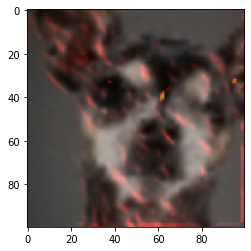

Ground_truth: Senior
Prediction: Senior
Confidence: 0.99700767


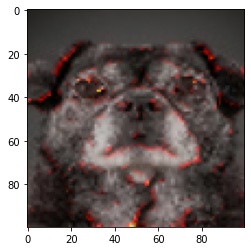

Ground_truth: Senior
Prediction: Adult
Confidence: 0.9485724


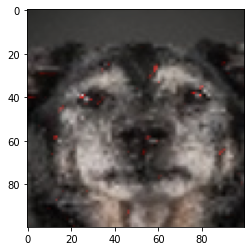

Ground_truth: Senior
Prediction: Senior
Confidence: 0.799079


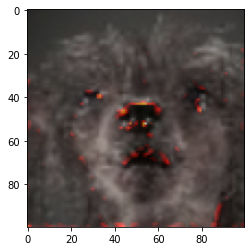

Ground_truth: Senior
Prediction: Young
Confidence: 0.8220051


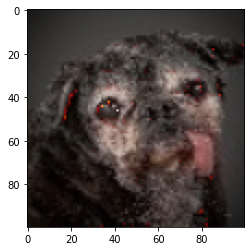

Correct cases: 2
Total cases: 5
Prediction accuracy: 0.4


In [21]:
gradCAM('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Senior/',ground_truth="Senior")

Ground_truth: Adult
Prediction: Young
Confidence: 0.77540386


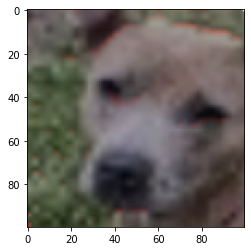

Ground_truth: Adult
Prediction: Adult
Confidence: 0.93586427


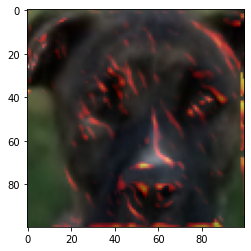

Ground_truth: Adult
Prediction: Adult
Confidence: 0.72872007


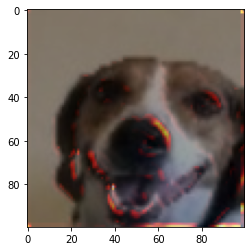

Ground_truth: Adult
Prediction: Adult
Confidence: 0.637034


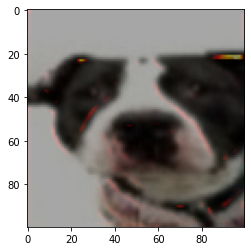

Ground_truth: Adult
Prediction: Adult
Confidence: 0.6013712


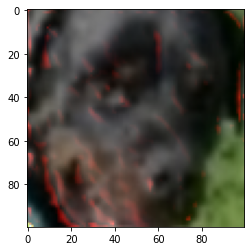

Ground_truth: Adult
Prediction: Adult
Confidence: 0.9743527


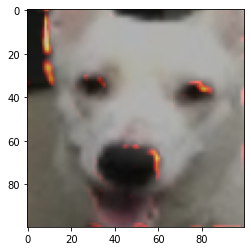

Ground_truth: Adult
Prediction: Young
Confidence: 0.5522608


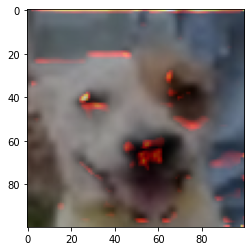

Ground_truth: Adult
Prediction: Young
Confidence: 0.97440696


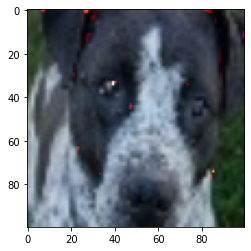

Ground_truth: Adult
Prediction: Young
Confidence: 0.7665854


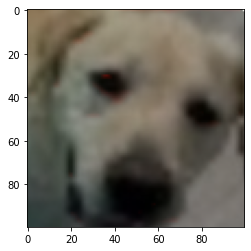

Ground_truth: Adult
Prediction: Young
Confidence: 0.5880348


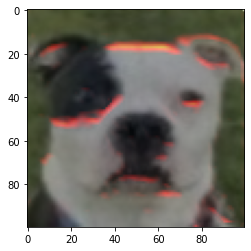

Ground_truth: Adult
Prediction: Young
Confidence: 0.9045287


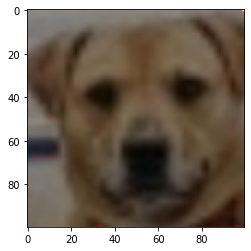

Correct cases: 5
Total cases: 11
Prediction accuracy: 0.45454545454545453


In [22]:
gradCAM('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Adult/',ground_truth="Adult")

Ground_truth: Young
Prediction: Young
Confidence: 0.51563805


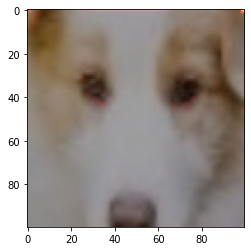

Ground_truth: Young
Prediction: Young
Confidence: 0.9841374


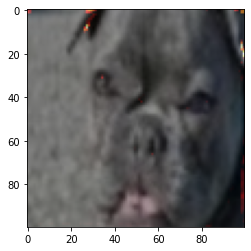

Ground_truth: Young
Prediction: Young
Confidence: 0.96404135


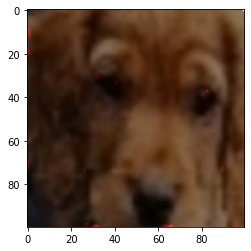

Ground_truth: Young
Prediction: Adult
Confidence: 0.5625827


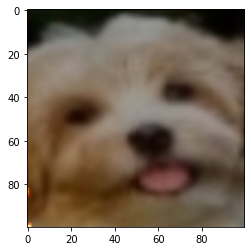

Ground_truth: Young
Prediction: Young
Confidence: 0.9607372


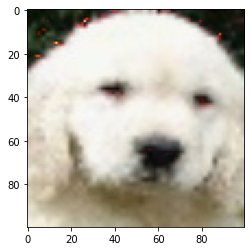

Ground_truth: Young
Prediction: Adult
Confidence: 0.9885079


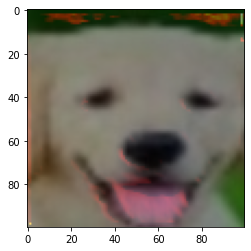

Ground_truth: Young
Prediction: Young
Confidence: 0.95755863


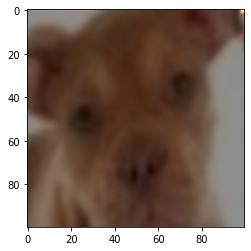

Correct cases: 5
Total cases: 7
Prediction accuracy: 0.7142857142857143


In [23]:
gradCAM('/home/data/data/kodeiri/ML_project/test_photos_downloaded/Young/',ground_truth="Young")